In [1]:
!pip install transformers
!pip install torch

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 데이터 불러오기
file_path = '/content/musma_bert_for_base_data.csv'
data = pd.read_csv(file_path)

# 뉴스 제목과 카테고리 열 선택
data = data[['news_title', 'label']]

# NaN 값 제거
data.dropna(inplace=True)

# 레이블 인코딩
categories = data['label'].unique()
label_map = {category: i for i, category in enumerate(categories)}
data['label'] = data['label'].map(label_map)

# 훈련 및 테스트 데이터 분리
train_data, test_data = train_test_split(data, test_size=0.2)


# 데이터의 처음 몇 행을 확인
data.head()
data.shape

(741, 2)

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset

# 토크나이저 및 모델 초기화
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))

# 데이터셋 클래스 정의
class NewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.labels = dataframe['label']
        self.texts = [tokenizer(text, padding='max_length', max_length=36, truncation=True, return_tensors="pt") for text in dataframe['news_title']]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels.iloc[idx]

# 데이터셋 생성 및 데이터 로더 설정
train_dataset = NewsDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)

test_dataset = NewsDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from transformers import AdamW, get_linear_schedule_with_warmup
import time
import torch

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=2e-5,
                  eps = 1e-8) # 0으로 나누는 것을 방지하기 위한 매우 작은 숫자
epochs = 10

def calculate_accuracy(preds, labels):
    preds_tensor = torch.tensor(preds)
    labels_tensor = torch.tensor(labels)

    # 1차원 텐서의 경우 직접 할당
    if preds_tensor.dim() == 1:
        predictions = preds_tensor
    else:
        _, predictions = torch.max(preds_tensor, dim=1)

    correct = (predictions == labels_tensor).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

In [13]:
from matplotlib import pyplot as plt

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [14]:
# 스케줄러 설정
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, # 워밍업 스텝
                                            num_training_steps=total_steps)

# 학습 루프
model.train()
for epoch in range(epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    start_time = time.time()
    total_loss = 0
    total_accuracy = 0

    for batch in train_loader:
        b_input_ids = batch[0]['input_ids'].squeeze(1).to(device)
        b_input_mask = batch[0]['attention_mask'].squeeze(1).to(device)
        b_labels = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        total_accuracy += calculate_accuracy(logits, b_labels).item()

        loss.backward()
        optimizer.step()

        # 학습률 감소
        scheduler.step()

    average_loss = total_loss / len(train_loader)
    average_accuracy = total_accuracy / len(train_loader)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s', flush=True)
    print(f'\tTrain Loss: {average_loss:.3f} | Train Acc: {average_accuracy*100:.2f}%')

    train_losses.append(average_loss)
    train_accuracies.append(average_accuracy)

    # 테스트 단계
    model.eval()
    total_test_loss = 0
    total_test_accuracy = 0
    predictions = []
    real_labels = []

    with torch.no_grad():
        for batch in test_loader:
            b_input_ids = batch[0]['input_ids'].squeeze(1).to(device)
            b_input_mask = batch[0]['attention_mask'].squeeze(1).to(device)
            b_labels = batch[1].to(device)

            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits

            total_test_loss += loss.item()
            total_test_accuracy += calculate_accuracy(logits, b_labels).item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            real_labels.extend(b_labels.cpu().numpy())

    average_test_loss = total_test_loss / len(test_loader)
    average_test_accuracy = total_test_accuracy / len(test_loader)

    test_losses.append(average_test_loss)
    test_accuracies.append(average_test_accuracy)

    # 테스트 손실 및 정확도 출력
    print(f'\tTest Loss: {average_test_loss:.3f} | Test Acc: {average_test_accuracy*100:.2f}%')

# 전체 모델 성능 평가
accuracy = calculate_accuracy(predictions, real_labels)
print('Overall Test Accuracy:', accuracy)

======== Epoch 1 / 10 ========


<ipython-input-12-75bd3b6b09a2>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_tensor = torch.tensor(preds)
<ipython-input-12-75bd3b6b09a2>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tensor = torch.tensor(labels)


Epoch: 01 | Epoch Time: 0.0m 7.285012483596802s
	Train Loss: 0.050 | Train Acc: 98.32%
	Test Loss: 1.520 | Test Acc: 75.87%
======== Epoch 2 / 10 ========
Epoch: 02 | Epoch Time: 0.0m 7.158298015594482s
	Train Loss: 0.041 | Train Acc: 98.82%
	Test Loss: 1.119 | Test Acc: 78.67%
======== Epoch 3 / 10 ========
Epoch: 03 | Epoch Time: 0.0m 7.176862716674805s
	Train Loss: 0.002 | Train Acc: 100.00%
	Test Loss: 1.290 | Test Acc: 76.93%
======== Epoch 4 / 10 ========
Epoch: 04 | Epoch Time: 0.0m 7.221691370010376s
	Train Loss: 0.001 | Train Acc: 100.00%
	Test Loss: 1.331 | Test Acc: 77.33%
======== Epoch 5 / 10 ========
Epoch: 05 | Epoch Time: 0.0m 7.257695198059082s
	Train Loss: 0.001 | Train Acc: 100.00%
	Test Loss: 1.377 | Test Acc: 77.07%
======== Epoch 6 / 10 ========
Epoch: 06 | Epoch Time: 0.0m 7.200680255889893s
	Train Loss: 0.001 | Train Acc: 100.00%
	Test Loss: 1.388 | Test Acc: 77.20%
======== Epoch 7 / 10 ========
Epoch: 07 | Epoch Time: 0.0m 7.18152928352356s
	Train Loss: 0.001 

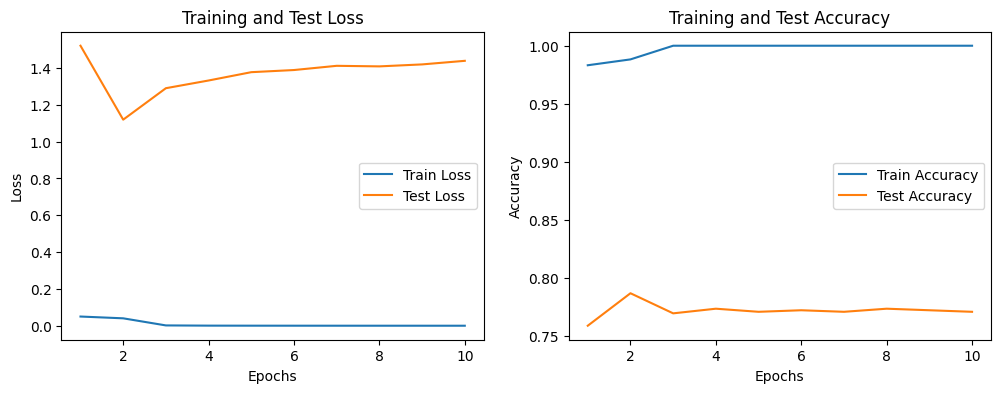

In [15]:
import matplotlib.pyplot as plt

# Epochs 범위 설정
epochs_range = range(1, epochs + 1)

# 훈련 손실 및 정확도 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 테스트 손실 및 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [22]:
# 모델 상태 저장
model_path = "/content/model.pth"  # 모델을 저장할 경로
torch.save(model.state_dict(), model_path)